# Project: K-Means Project / House Grouping System


# Step 1: Import Essential Libraries 

In [ ]:
# Libraries specialized "expert kits" to plug into Python essential for EDA.
import joblib
import requests
import os
import json
import pickle # -- Binary (unreadable by humans) -- Can save almost any Python object -- Very fast for complex objects --
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from numpy._core.defchararray import upper
from pathlib import Path
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest, f_regression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Step 2: Problem Statement / Data Collection
## 2.1 Description of the Problem
- We want to be able to classify houses according to their region and median income. 
- To do this, we will use the famous California Housing dataset. 
- It was constructed using data from the 1990 California census. It contains one row per census block group. A block group is the smallest geographic unit for which US Census data is published.
- Be sure to conveniently split the dataset into train and test as we have seen in previous lessons. 
- Although these sets are not used to obtain statistics, you can use them to train the unsupervised algorithm and then to make predictions about new points to predict the cluster they are associated with.

* **Column Description**:
* In this case, we are only interested in the Latitude, Longitude and MedInc columns.

## 2.2 Inicitial Loading and Inspection

In [2]:
def setup_project_structure(base_path, subfolders):
    """Creates a standard data science directory tree."""
    for folder in subfolders:
        folder_path = Path(base_path) / folder
        folder_path.mkdir(parents=True, exist_ok=True)
    print(f"Project structure initialized in: {base_path}")

def download_dataset_to_raw(url, full_path):
    """Downloads a file to a specific path."""
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        with open(full_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
            
        print(f"Download successful! Saved to: {full_path}")
        return True
    except Exception as e:
        print(f"Download failed: {e}")
        return False

    except requests.exceptions.RequestException as e:
        print(f"An error occurred during the download: {e}")
        return False
    
# --- CONFIGURATION ---
BASE_DIR = "../data"
FOLDERS = ["raw", "processed", "interim"]
DATA_URL = "https://breathecode.herokuapp.com/asset/internal-link?id=439&path=housing.csv"
TARGET_FILE = "housing.csv"

# EXECUTION
# Build the whole house
setup_project_structure(BASE_DIR, FOLDERS)

# Put the data in the 'raw' room
RAW_FILE_PATH = Path(BASE_DIR) / "raw" / TARGET_FILE
download_dataset_to_raw(DATA_URL, RAW_FILE_PATH)

Project structure initialized in: ../data
Download successful! Saved to: ../data/raw/housing.csv


True

In [3]:
# Define the full path again for reading
try:
    df = pd.read_csv(RAW_FILE_PATH, sep= None, engine= 'python')
    print("\nDataset loaded successfully into a DataFrame:")
except FileNotFoundError:
    print(f"\nError: File not found at {RAW_FILE_PATH}")


Dataset loaded successfully into a DataFrame:


# Step 3: Exploration and Data Cleaning

## 3.1 DataSet Dimension & Tipology Visibility

In [4]:
row, col = df.shape
print(f"The Dataset has {row} number of rows and {col} columns.")

The Dataset has 20640 number of rows and 9 columns.


## 3.2 Top 5 Row View

In [5]:
top_five_data = df.head()
print("These are the DataSet top 5 columns view to be analized:")
print(tabulate(top_five_data, headers='keys', tablefmt='psql'))

These are the DataSet top 5 columns view to be analized:
+----+----------+------------+------------+-------------+--------------+------------+------------+-------------+---------------+
|    |   MedInc |   HouseAge |   AveRooms |   AveBedrms |   Population |   AveOccup |   Latitude |   Longitude |   MedHouseVal |
|----+----------+------------+------------+-------------+--------------+------------+------------+-------------+---------------|
|  0 |   8.3252 |         41 |    6.98413 |     1.02381 |          322 |    2.55556 |      37.88 |     -122.23 |         4.526 |
|  1 |   8.3014 |         21 |    6.23814 |     0.97188 |         2401 |    2.10984 |      37.86 |     -122.22 |         3.585 |
|  2 |   7.2574 |         52 |    8.28814 |     1.07345 |          496 |    2.80226 |      37.85 |     -122.24 |         3.521 |
|  3 |   5.6431 |         52 |    5.81735 |     1.07306 |          558 |    2.54795 |      37.85 |     -122.25 |         3.413 |
|  4 |   3.8462 |         52 |    6.2818

## 3.3 Data Types and Non-Nulls Values Overview.

In [6]:
print("This is the information about Non-Null and Dtype:\n================================================")
print(df.info())

This is the information about Non-Null and Dtype:
<class 'pandas.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None


## 3.4 Check Unique

In [7]:
print("These are the Unique Values for each columns on the Dataset:\n============================================================")
print(df.nunique())

These are the Unique Values for each columns on the Dataset:
MedInc         12928
HouseAge          52
AveRooms       19392
AveBedrms      14233
Population      3888
AveOccup       18841
Latitude         862
Longitude        844
MedHouseVal     3842
dtype: int64


## 3.5 Check for Duplicates Values

In [8]:
# Since there are no identifiers, duplicate check looked at the entire row.
duplicate_val = df.duplicated().sum()
print(f"<< {duplicate_val} >> duplicated value in the dataset.")

<< 0 >> duplicated value in the dataset.


## 3.6 Duplicates Inspection

In [9]:
# Finding duplicates is a vital cleaning step.
duplicate_rows = df[df.duplicated(keep= False)]
print("Table with duplicates rows (in case they are and only for visibility):\n======================================================")
print(tabulate(duplicate_rows.head(24), headers= "keys", tablefmt= "psql"))

Table with duplicates rows (in case they are and only for visibility):
+----------+------------+------------+-------------+--------------+------------+------------+-------------+---------------+
| MedInc   | HouseAge   | AveRooms   | AveBedrms   | Population   | AveOccup   | Latitude   | Longitude   | MedHouseVal   |
|----------+------------+------------+-------------+--------------+------------+------------+-------------+---------------|
+----------+------------+------------+-------------+--------------+------------+------------+-------------+---------------+


## 3.7 Drop Duplicates

In [10]:
df = df.drop_duplicates().reset_index(drop= True)
print(df.shape)
print(tabulate(df.head(), headers='keys', tablefmt='psql'))

(20640, 9)
+----+----------+------------+------------+-------------+--------------+------------+------------+-------------+---------------+
|    |   MedInc |   HouseAge |   AveRooms |   AveBedrms |   Population |   AveOccup |   Latitude |   Longitude |   MedHouseVal |
|----+----------+------------+------------+-------------+--------------+------------+------------+-------------+---------------|
|  0 |   8.3252 |         41 |    6.98413 |     1.02381 |          322 |    2.55556 |      37.88 |     -122.23 |         4.526 |
|  1 |   8.3014 |         21 |    6.23814 |     0.97188 |         2401 |    2.10984 |      37.86 |     -122.22 |         3.585 |
|  2 |   7.2574 |         52 |    8.28814 |     1.07345 |          496 |    2.80226 |      37.85 |     -122.24 |         3.521 |
|  3 |   5.6431 |         52 |    5.81735 |     1.07306 |          558 |    2.54795 |      37.85 |     -122.25 |         3.413 |
|  4 |   3.8462 |         52 |    6.28185 |     1.08108 |          565 |    2.18147 | 

## 3.8 Eliminate Irrelevant Information

- It is very difficult at first glance to determine what varibale is irrlevant.
- So I will run an analysis involving a first correlation list and a heatmap between the numerical variable and start depurating the list.

In [11]:
# 1. Drop identifiers that don't help the math in case we have them
# We keep the numeric columns and drop unique text strings
df_numeric = df.select_dtypes(include=[np.number])

""" NO NEED TO RUN THIS CODE AS WE DONT HAVE A TARGET VARIAVLE FOR THE K-MEANS MODEL """
# 2. Let's assume 'quality' is our target (y)
# Let's check the top correlations to confirm
# target = 'INCLUDE TARGET VARIABLE' 

# if target in df_numeric.columns:
#     correlations = df_numeric.corr()[target].sort_values(ascending=False)
#     print("--- Top Correlations with Target ---")
#     print(tabulate(pd.DataFrame(correlations), headers= "keys", tablefmt= "psql"))
# else:
#     print(f"Target '{target}' not found. Please check df.columns for the exact name.")

' NO NEED TO RUN THIS CODE AS WE DONT HAVE A TARGET VARIAVLE FOR THE K-MEANS MODEL '

In [12]:
# 1. Check for 'Hidden' missing values
# Columns where a 0 is biologically impossible
cols_to_fix = df_numeric.columns

print("Zero counts per column:")
for col in cols_to_fix:
    print(f"{col}: {(df[col] == 0).sum()} zeros")

# 2. Visualize the Class Imbalance (Target)
# sns.countplot(x= target, data= df, hue= target, palette='viridis')
# plt.title('Quality Outcome Distribution (3-5 "Low" 6-8 "High Quality)')
# plt.show()

Zero counts per column:
MedInc: 0 zeros
HouseAge: 0 zeros
AveRooms: 0 zeros
AveBedrms: 0 zeros
Population: 0 zeros
AveOccup: 0 zeros
Latitude: 0 zeros
Longitude: 0 zeros
MedHouseVal: 0 zeros


### 3.8.1 Conclusion on Zero Count / Quality Chart
- Very powerfull data with no zeros's in every row.

# Step 4: Analysis of Univariate Variables
## 4.1 Numeric Variable Analysis

In [13]:
# Select only columns with 'int or float' data type (numeric)
numerics = df.select_dtypes(include= ['number']).columns.tolist()
print(f"Numeric variables: {numerics}")

Numeric variables: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']


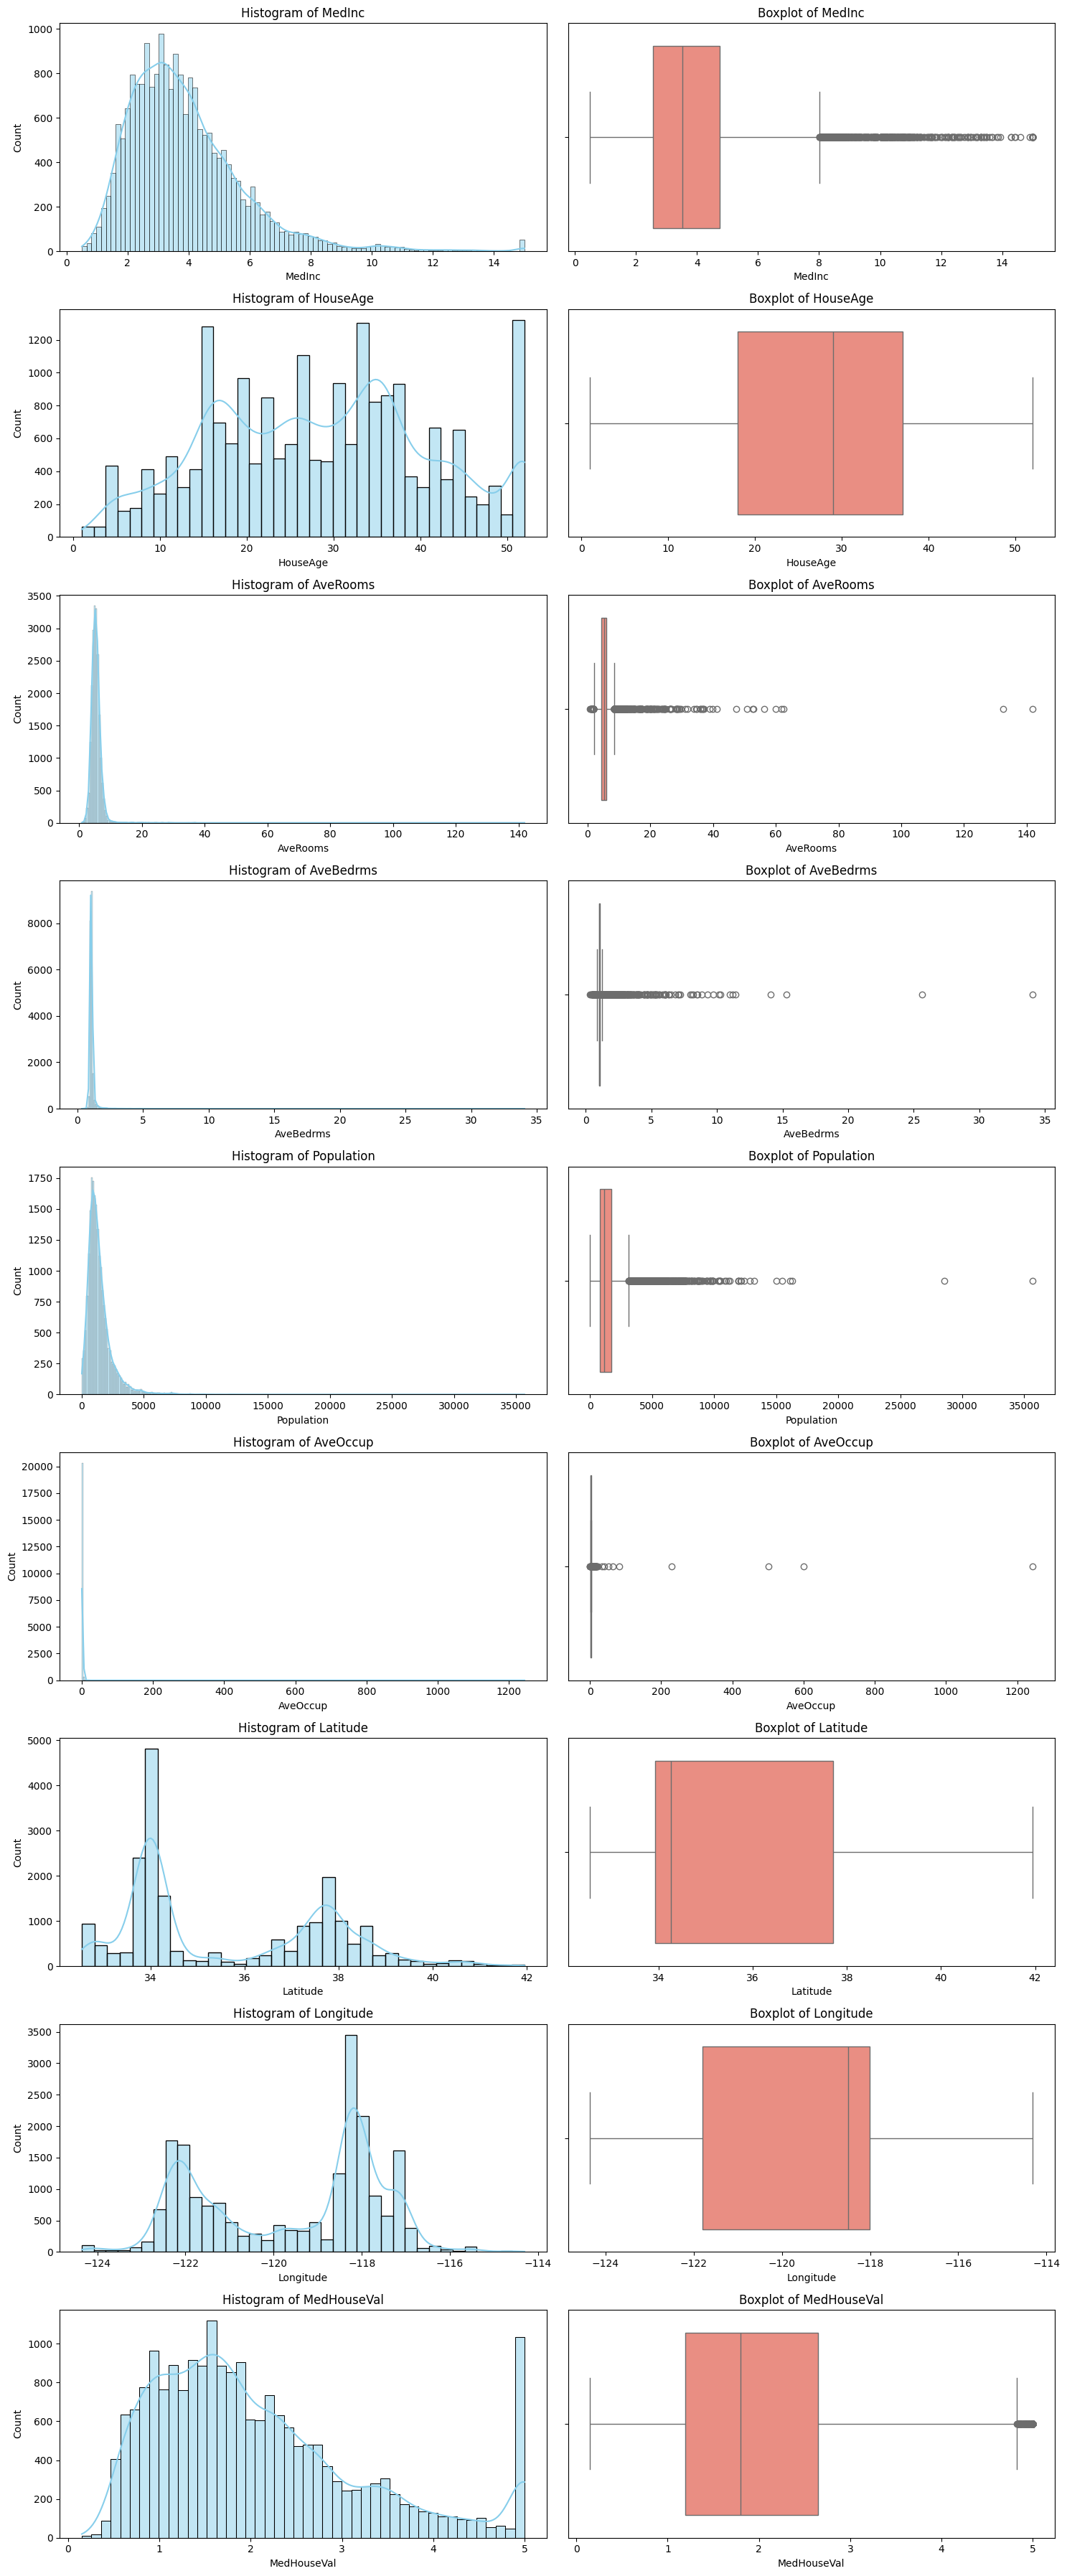

In [14]:
# Creating histplot and boxplot for the numeric variables
if len(numerics) != 0:
    nrows = len(numerics)
    ncols = 2
    fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize=(15, 4 * nrows))

    for i, col in enumerate(numerics):
        sns.histplot(df[col], kde=True, ax=axes[i, 0], color="skyblue")
        axes[i, 0].set_title(f'Histogram of {col}')
        sns.boxplot(x=df[col], ax=axes[i, 1], color="salmon")
        axes[i, 1].set_title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()
else:
    print("There are no numercial variables or the list numerics might be empty")

### 4.1.1 Conclusions for Numerical Variable Charts
- **Latitude & Longitude**: The histograms show two very clear peaks. These represent the major population.
- Look at **AveRooms, AveBedrms, Population, and AveOccup**. The boxplots show extreme outliers—single points stretching far to the right.
- K-Means is extremely sensitive to outliers.
- **HouseAge & MedHouseVal**: Notice the tall bar at the far right of the HouseAge and MedHouseVal histograms. Everything over 50 years or $500k was grouped together.

# Step 5: Multivariate Variables Analysis
## 5.1 Numerical-Numerical Analysis

In [15]:
""" NO NEED TO RUN THIS CODE AS WE DONT HAVE A TARGET VARIAVLE FOR THE K-MEANS MODEL """
# # 1. Excluding the target. The condition is to avoid ploting the target with itself.
# if 'quality' in numerics: numerics.remove('quality')
# target_num = 'quality'

# # 2. Calculate Grid Size
# ncols = 3
# group_chart = math.ceil(len(numerics) / ncols)
# nrows = group_chart * 2 # Double the rows (one for Reg, one for Heatmap)

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 4 * nrows))

# for chart_idx in range(group_chart):
#     # Determine which row we are on for Regplots
#     reg_row = chart_idx * 2
#     # The Heatmap row is always the one right below it
#     heat_row = reg_row + 1

#     # Get the 3 variables for this group
#     start = chart_idx * ncols
#     end = start + ncols
#     current_vars = numerics[start:end]

#     for col_idx, col in enumerate(current_vars):
#         # --- Plot 1: Regplot ---
#         sns.regplot(data= df, x= col, y= target_num, ax= axes[reg_row, col_idx], scatter_kws={'alpha':0.05}, line_kws={'color':'red'})
#         axes[reg_row, col_idx].set_title(f'Regplot: {col}')
#         if col_idx > 0:
#             axes[reg_row, col_idx].set(ylabel= None)
#         # --- Plot 2: Heatmap ---
#         sns.heatmap(df[[col, target_num]].corr(), annot=True, fmt=".2f", ax=axes[heat_row, col_idx], cmap='coolwarm', cbar= False)
#         axes[heat_row, col_idx].set_title(f'Corr: {col}')
# # 4. Hide empty slots (if any)
# for col_idx in range(len(current_vars), ncols):
#     axes[reg_row, col_idx].set_visible(False)
#     axes[heat_row, col_idx].set_visible(False)


# plt.tight_layout(pad=3.0)
# plt.show()

' NO NEED TO RUN THIS CODE AS WE DONT HAVE A TARGET VARIAVLE FOR THE K-MEANS MODEL '

## 5.2 Num - Num Analysis (Complete)

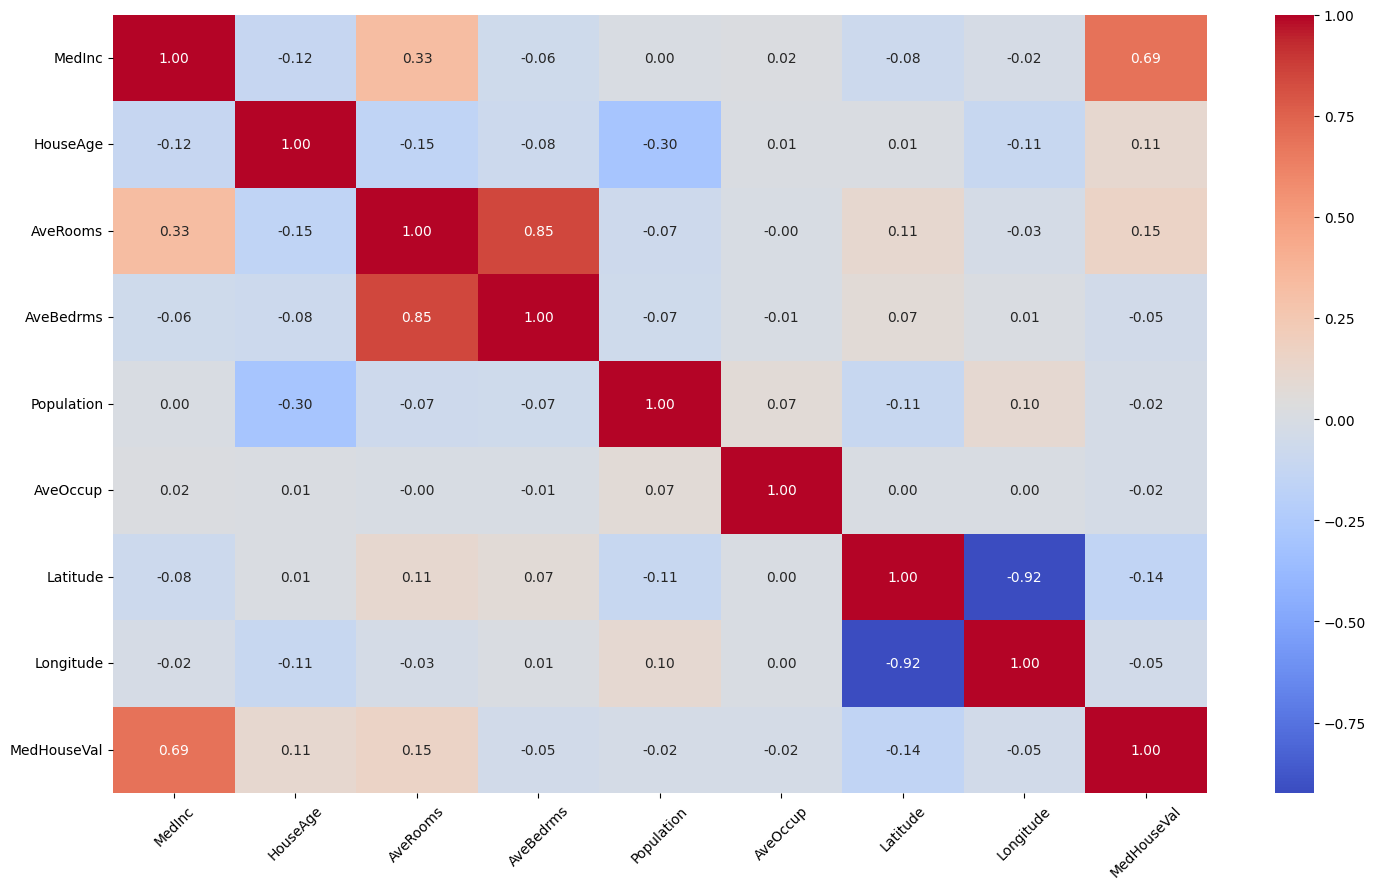

In [16]:
# Creating heatmap chart to analyze complete variables correlation
cols_num = df.select_dtypes(include= ['number']).columns.tolist()
fig, ax = plt.subplots(figsize= (15, 9))
sns.heatmap(df[cols_num].corr(method= "pearson"), annot= True, fmt= ".2f", cmap= "coolwarm", ax= ax).tick_params(axis= 'x', rotation= 45)
plt.tight_layout()
plt.show()

### 5.2.1 Conclusion Correlation Heatmap
- **Latitude & Longitude**: The correlation between these two is -0.92. Because they are so tightly linked, these two features effectively act as a single "Location" coordinate. K-Means will easily use these to separate the North from the South.
- **MedInc & MedHouseVal**: There is a strong positive correlation of 0.69. If I only want to group by income, I might consider dropping MedHouseVal to ensure the AI doesn't get confused by high-priced areas.
- **AveRooms & AveBedrms**: I have a high correlation of 0.85 here. Since the goal is Region and Income, I strongly recommend dropping AveBedrms and keeping only AveRooms.
- **Independent" Variables**: Features like HouseAge, Population, and AveOccup have almost zero correlation with location or income. Meybe they will "distract" the model.

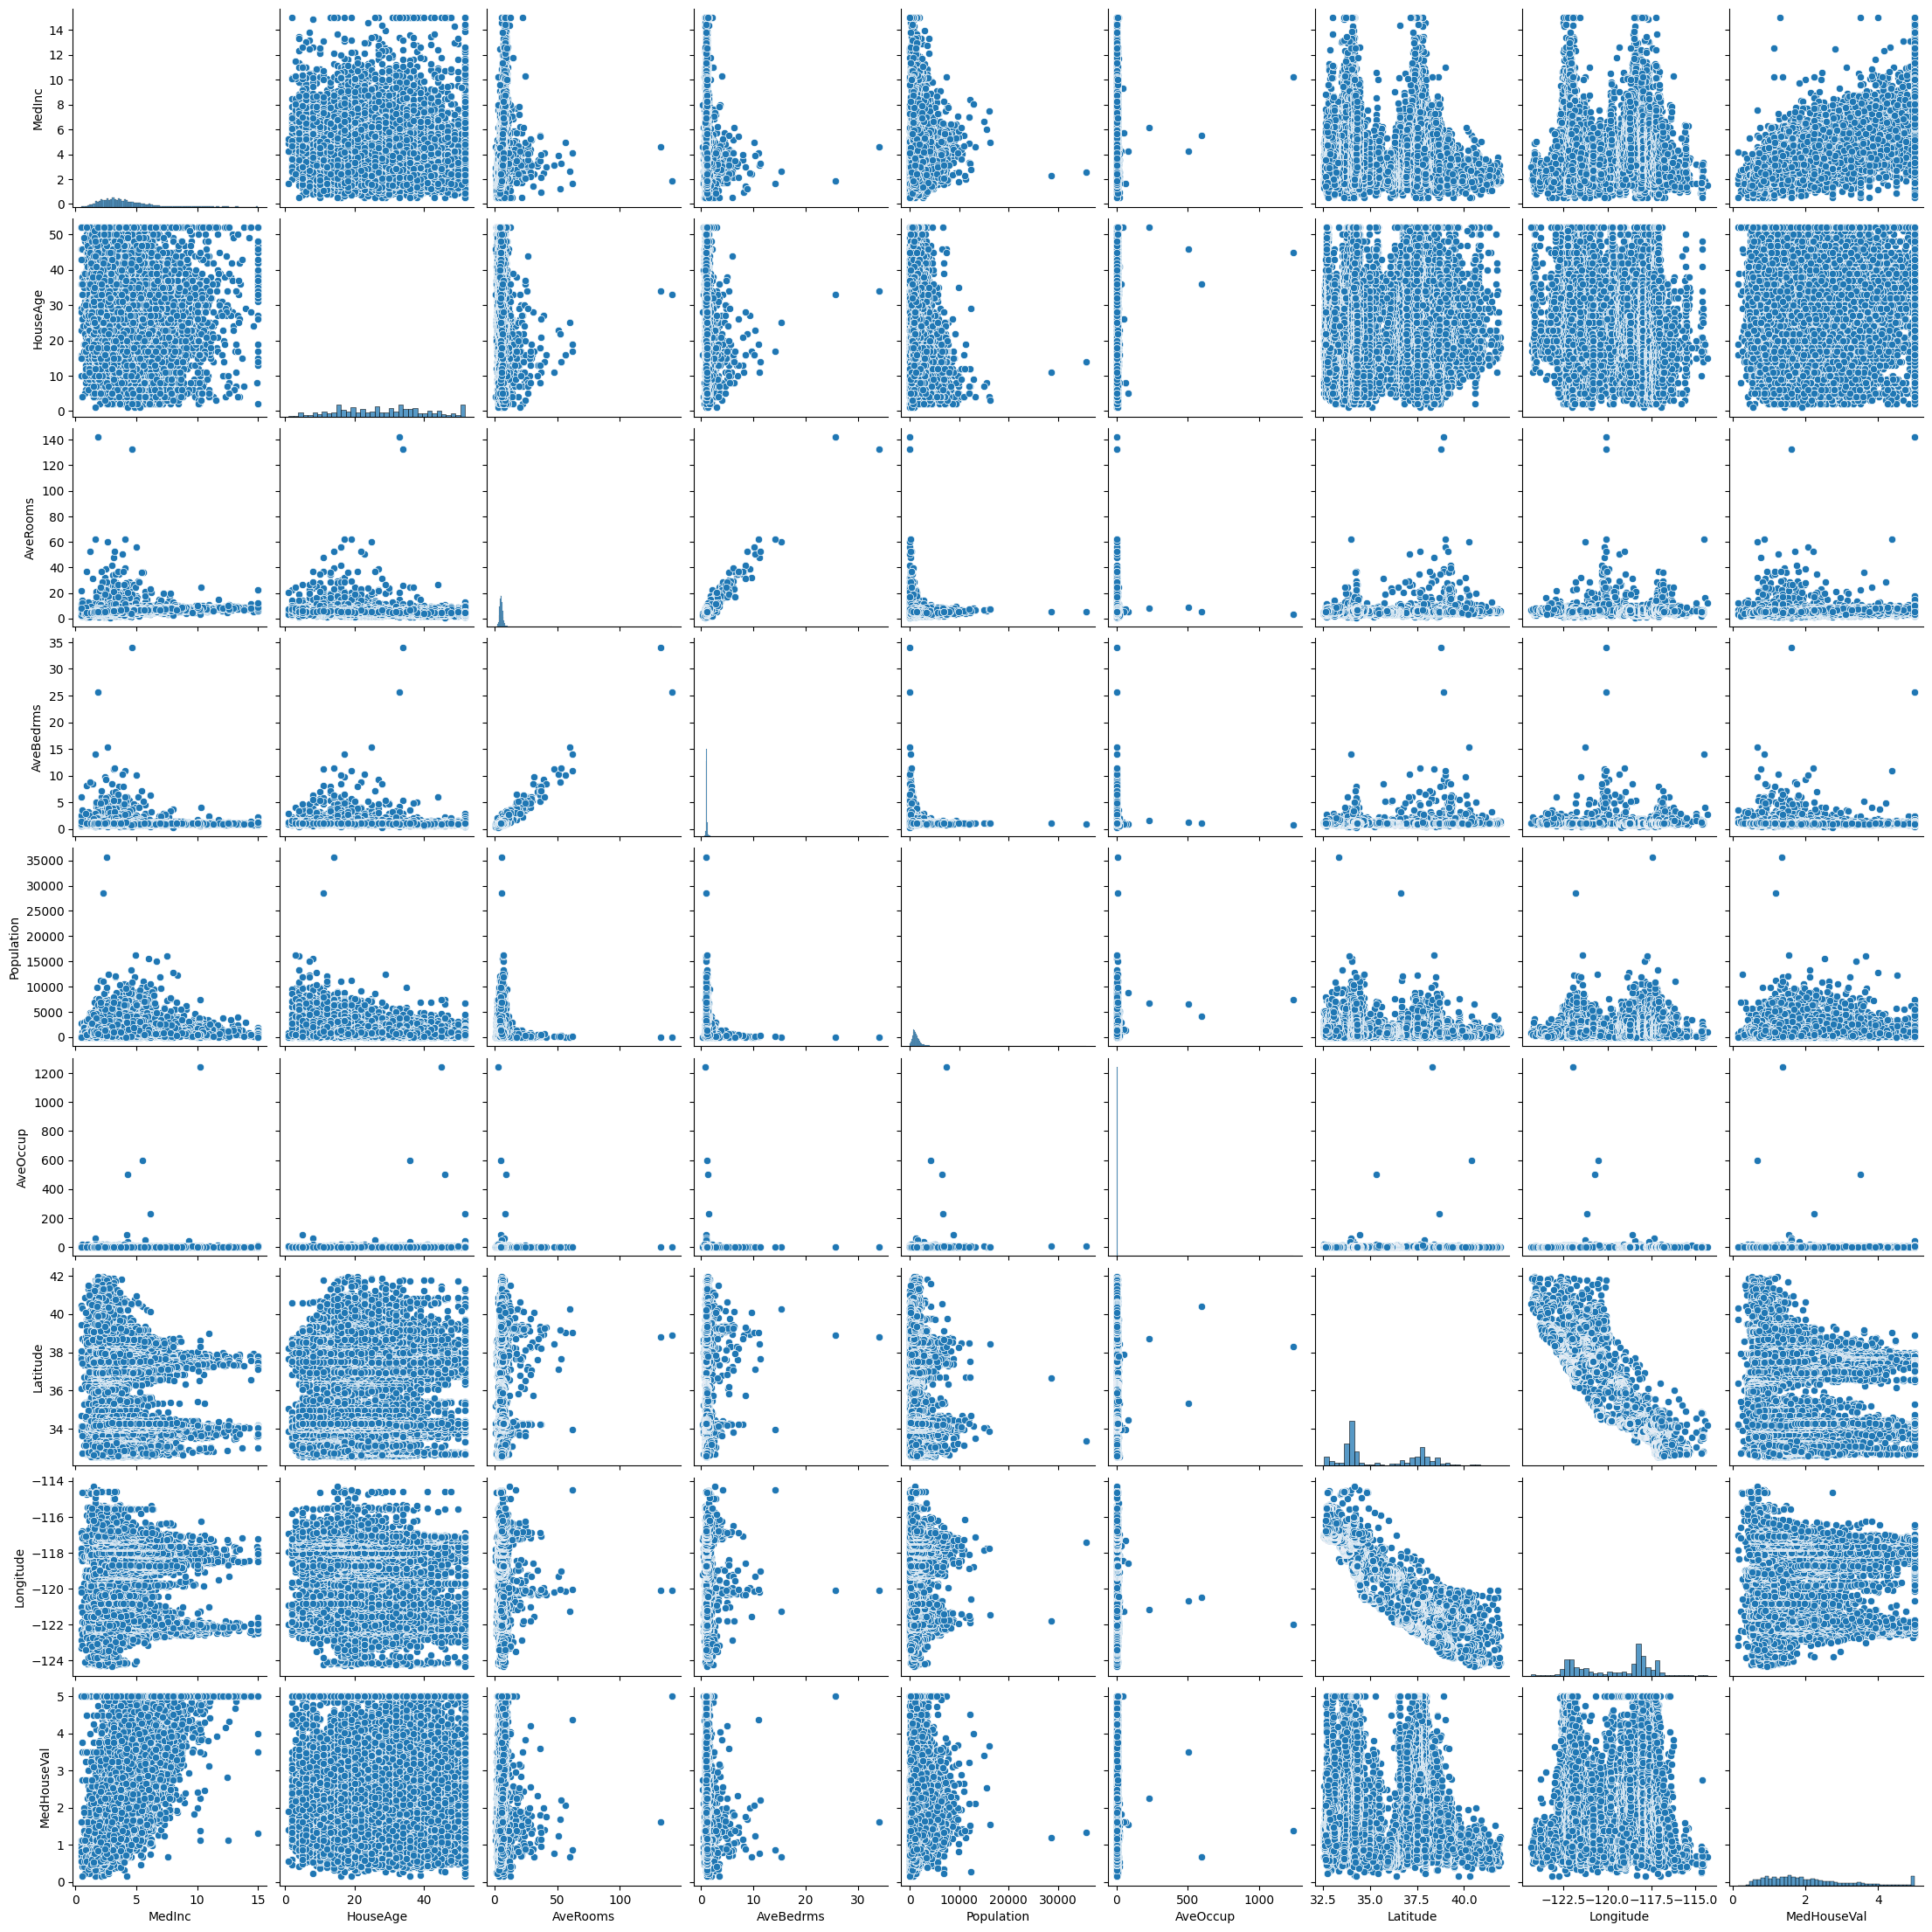

In [17]:
# Creating pairplot to have a variables behaviour visibility 
sns.pairplot(data= df)

## 5.3 Final DataSet Columns
- KEEP: HouseAge, Latitude, Longitude, and MedInc. the last 3 are the "Core Trio."
- DROPPING: AveBedrms, Population, and AveOccup. They likely won't help you find regional/income patterns and might actually blur the clusters.
- **final_cols** = ['MedInc', 'HouseAge', 'AveRooms', 'Latitude', 'Longitude']


In [18]:
final_cols = ['MedInc', 'HouseAge', 'AveRooms', 'Latitude', 'Longitude']
df = df[final_cols]

In [19]:
print(tabulate(df.describe(), headers= "keys", tablefmt= "psql"))

+-------+-------------+------------+--------------+-------------+-------------+
|       |      MedInc |   HouseAge |     AveRooms |    Latitude |   Longitude |
|-------+-------------+------------+--------------+-------------+-------------|
| count | 20640       | 20640      | 20640        | 20640       | 20640       |
| mean  |     3.87067 |    28.6395 |     5.429    |    35.6319  |  -119.57    |
| std   |     1.89982 |    12.5856 |     2.47417  |     2.13595 |     2.00353 |
| min   |     0.4999  |     1      |     0.846154 |    32.54    |  -124.35    |
| 25%   |     2.5634  |    18      |     4.44072  |    33.93    |  -121.8     |
| 50%   |     3.5348  |    29      |     5.22913  |    34.26    |  -118.49    |
| 75%   |     4.74325 |    37      |     6.05238  |    37.71    |  -118.01    |
| max   |    15.0001  |    52      |   141.909    |    41.95    |  -114.31    |
+-------+-------------+------------+--------------+-------------+-------------+


# Step 6: Feature Engineering
## 6.1 Outlier analysis

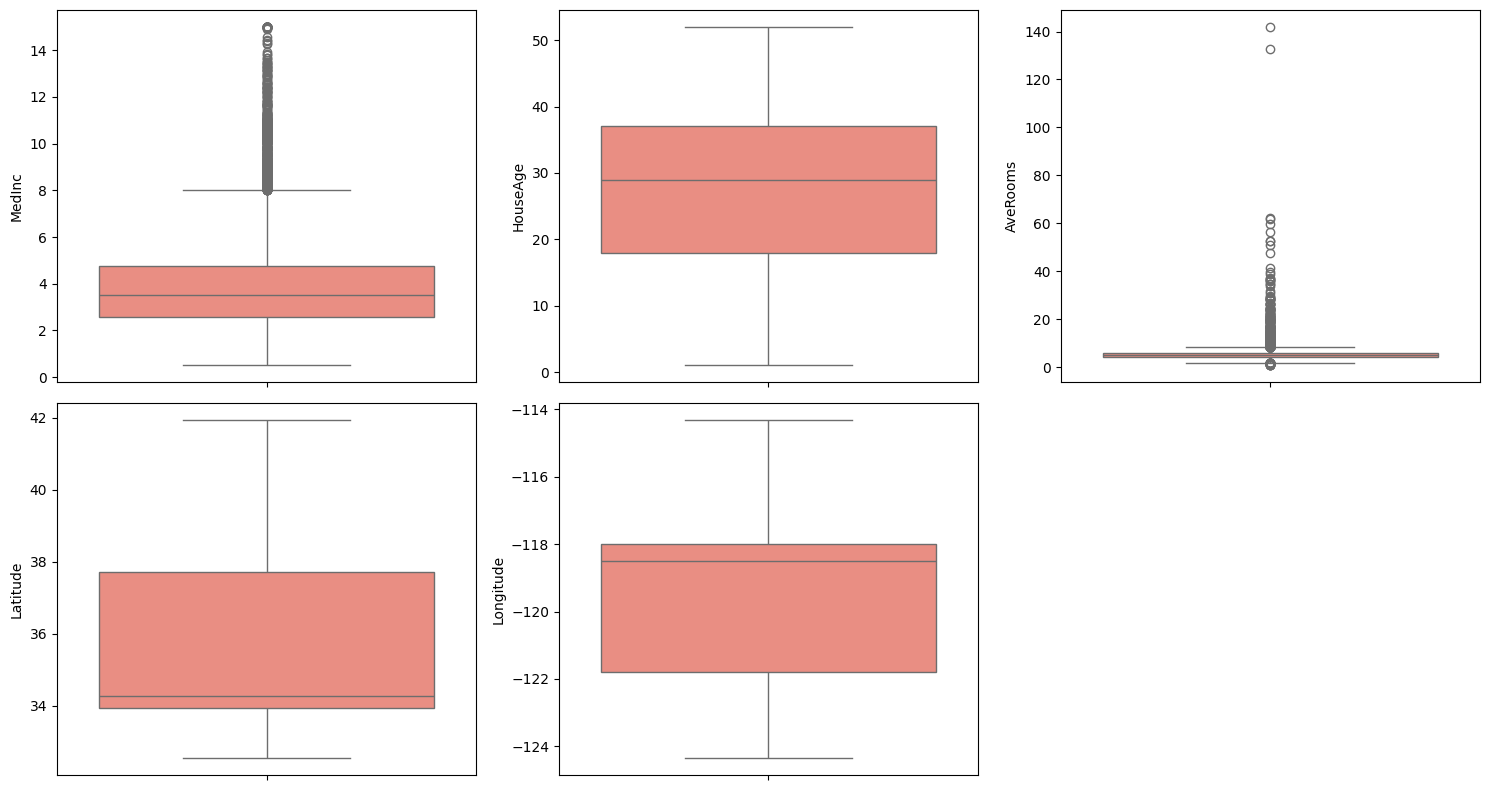

In [20]:
# Creating boxplot to understand the outliers in each variable
ncols = 3
nrows = math.ceil(len(final_cols) / ncols)
fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize= (15, 4 * nrows))

axes = axes.flatten()
for i, col in enumerate(final_cols):
    sns.boxplot(data= df, y= col, ax= axes[i], color= 'salmon')
for j in range(len(final_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 6.1.1 Conclusion Boxplots Charts
- Based on your boxplots, we have a clear visualization of the "noise" vs. "signal" in the data. 
- I think that in K-Means, these outliers are critical because they can act like magnets, pulling the cluster centers (centroids) away from the actual density of the neighborhoods.
- let's check it out!!

In [21]:
# Necessary coding to replace outliers creating upper and lower limits
df_WITH_outliers = df.copy()
df_WITHOUT_outliers = df.copy()

outliers_cols = ['MedInc', 'AveRooms']

def replace_outliers(column, data_df):
   col_stats = data_df[column].describe()
   col_iqr = col_stats["75%"] - col_stats["25%"]
   upper_limit = round(float(col_stats["75%"] + 1.5 * col_iqr), 2)
   lower_limit = round(float(col_stats["25%"] - 1.5 * col_iqr), 2)

   if lower_limit < 0: lower_limit = min(df[column])
   # Let's take out upper outliers 
   data_df[column] = data_df[column].apply(lambda x: x if (x <= upper_limit) else upper_limit)
   # Let's take out lower outliers 
   data_df[column] = data_df[column].apply(lambda x: x if (x >= lower_limit) else lower_limit)
   return data_df.copy(), [lower_limit, upper_limit]

outliers_dict = {}
for column in outliers_cols:
   df_WITHOUT_outliers, limits = replace_outliers(column, df_WITHOUT_outliers)
   outliers_dict.update({column: limits})

print(f"Limits: {outliers_dict}") # This jason needs to be saved

Limits: {'MedInc': [0.4999, 8.01], 'AveRooms': [2.02, 8.47]}


In [22]:
# Saving the json dictionary for outliers limit
with open('../data/interim/outliers_dict.json', 'w') as f:
     json.dump(outliers_dict, f)

## 6.2 Missing Value Analysis

In [23]:
print("The list below, will show if dataset WITH outliers has any null value for the variables:")
print(df_WITH_outliers.isnull().sum().sort_values(ascending= False))

The list below, will show if dataset WITH outliers has any null value for the variables:
MedInc       0
HouseAge     0
AveRooms     0
Latitude     0
Longitude    0
dtype: int64


In [24]:
print("The list below, will show if dataset WITHOUT outliers has any null value for the variables:")
print(df_WITHOUT_outliers.isnull().sum().sort_values(ascending= False))

The list below, will show if dataset WITHOUT outliers has any null value for the variables:
MedInc       0
HouseAge     0
AveRooms     0
Latitude     0
Longitude    0
dtype: int64


## 6.3 Inference of New Features
* I will not conduct any merging features at this point. 
* I think it's a smart move for the first iteration of an Unsupervised Learning project. 
* By avoiding manual feature engineering (like merging variables), I allow the K-Means algorithm to reveal the natural structure of the data exactly as it is.

## 6.4 Feature Scaling

In [25]:
# 1. Define the the features
all_features = ['MedInc', 'HouseAge', 'AveRooms', 'Latitude', 'Longitude']

# 2. Extract and Scale
X_WITH_outliers = df_WITH_outliers[all_features]
X_WITHOUT_outliers = df_WITHOUT_outliers[all_features]

X_train_WITH_outliers, X_test_WITH_outliers = train_test_split(X_WITH_outliers, test_size = 0.2, random_state = 10)
X_train_WITHOUT_outliers, X_test_WITHOUT_outliers = train_test_split(X_WITHOUT_outliers, test_size = 0.2, random_state = 10)

In [26]:
X_train_WITHOUT_outliers.shape

(16512, 5)

In [27]:
X_test_WITHOUT_outliers.shape

(4128, 5)

In [28]:
# Normalization and MIN_MAX Scaling
# WE NEED TO SAVE 3 OCCURRENCE: 1) DATASET PLANE (WITH NO CHANGES), 2) DATASET NORMALIZED, 3) DATASET MIN-MAX

## NORMALIZATION
### WITH OUTLIERS
norm_WITH_outliers = StandardScaler() # StandardScaler(), used to "normalize" or "resize" your data so that all your features are on the same scale. 
# .fit(), The "Learning"
norm_WITH_outliers.fit(X_train_WITH_outliers) # Phase. the scaler (or model) looks at your data and calculates the necessary parameters. It does not change the data; it only learns from it.

# .transform(), The "Applying" Phase.
# NOTE: .fit_transform() — The "Shortcut" --> This is simply a convenience method that does both steps at the same time on the same piece of data. --- Use this on your Training Data ---
X_train_WITH_outliers_norm = norm_WITH_outliers.transform(X_train_WITH_outliers) # This uses the parameters calculated during .fit() to actually modify the data.
X_train_WITH_outliers_norm = pd.DataFrame(X_train_WITH_outliers_norm, index = X_train_WITH_outliers.index, columns = all_features) # We need to convert to DataFrame the transform with this variable

X_test_WITH_outliers_norm = norm_WITH_outliers.transform(X_test_WITH_outliers)
X_test_WITH_outliers_norm = pd.DataFrame(X_test_WITH_outliers_norm, index = X_test_WITH_outliers.index, columns = all_features)

### WITHOUT OUTLIERS
norm_WITHOUT_outliers = StandardScaler()
norm_WITHOUT_outliers.fit(X_train_WITHOUT_outliers)

X_train_WITHOUT_outliers_norm = norm_WITHOUT_outliers.transform(X_train_WITHOUT_outliers)
X_train_WITHOUT_outliers_norm = pd.DataFrame(X_train_WITHOUT_outliers_norm, index = X_train_WITHOUT_outliers.index, columns = all_features)

X_test_WITHOUT_outliers_norm = norm_WITHOUT_outliers.transform(X_test_WITHOUT_outliers)
X_test_WITHOUT_outliers_norm = pd.DataFrame(X_test_WITHOUT_outliers_norm, index = X_test_WITHOUT_outliers.index, columns = all_features)


## SCALED MIN_MAX
### WITH OUTLIERS
scaler_WITH_outliers = MinMaxScaler() # MinMaxScaler is a scaling technique that transforms the data so that all values fall within a specific range, most commonly between 0 and 1.
scaler_WITH_outliers.fit(X_train_WITH_outliers)

X_train_WITH_outliers_scal = scaler_WITH_outliers.transform(X_train_WITH_outliers)
X_train_WITH_outliers_scal = pd.DataFrame(X_train_WITH_outliers_scal, index = X_train_WITH_outliers.index, columns = all_features)

X_test_WITH_outliers_scal = scaler_WITH_outliers.transform(X_test_WITH_outliers)
X_test_WITH_outliers_scal = pd.DataFrame(X_test_WITH_outliers_scal, index = X_test_WITH_outliers.index, columns = all_features)

### WITHOUT OUTLIERS
scaler_WITHOUT_outliers = MinMaxScaler()
scaler_WITHOUT_outliers.fit(X_train_WITHOUT_outliers)

X_train_WITHOUT_outliers_scal = scaler_WITHOUT_outliers.transform(X_train_WITHOUT_outliers)
X_train_WITHOUT_outliers_scal = pd.DataFrame(X_train_WITHOUT_outliers_scal, index = X_train_WITHOUT_outliers.index, columns = all_features)

X_test_WITHOUT_outliers_scal = scaler_WITHOUT_outliers.transform(X_test_WITHOUT_outliers)
X_test_WITHOUT_outliers_scal = pd.DataFrame(X_test_WITHOUT_outliers_scal, index = X_test_WITHOUT_outliers.index, columns = all_features)

In [29]:
# DATASETS that have been created so far in previous steps from the feature engineering

X_train_WITH_outliers.to_excel("../data/processed/X_train_WITH_outliers.xlsx", index = False)
X_train_WITH_outliers_norm.to_excel("../data/processed/X_train_WITH_outliers_norm.xlsx", index = False)
X_train_WITH_outliers_scal.to_excel("../data/processed/X_train_WITH_outliers_scal.xlsx", index = False)
X_train_WITHOUT_outliers.to_excel("../data/processed/X_train_WITHOUT_outliers.xlsx", index = False)
X_train_WITHOUT_outliers_norm.to_excel("../data/processed/X_train_WITHOUT_outliers_norm.xlsx", index = False)
X_train_WITHOUT_outliers_scal.to_excel("../data/processed/X_train_WITHOUT_outliers_scal.xlsx", index = False)

X_test_WITH_outliers.to_excel("../data/processed/X_test_WITH_outliers.xlsx", index = False)
X_test_WITH_outliers_norm.to_excel("../data/processed/X_test_WITH_outliers_norm.xlsx", index = False)
X_test_WITH_outliers_scal.to_excel("../data/processed/X_test_WITH_outliers_scal.xlsx", index = False)
X_test_WITHOUT_outliers.to_excel("../data/processed/X_test_WITHOUT_outliers.xlsx", index = False)
X_test_WITHOUT_outliers_norm.to_excel("../data/processed/X_test_WITHOUT_outliers_norm.xlsx", index = False)
X_test_WITHOUT_outliers_scal.to_excel("../data/processed/X_test_WITHOUT_outliers_scal.xlsx", index = False)

# y_train.to_excel("../data/processed/y_train.xlsx", index = False)
# y_test.to_excel("../data/processed/y_test.xlsx", index = False)

# SCALERS --> Saving the models

with open("../models/norm_WITH_outliers.pkl", "wb") as file:
  pickle.dump(norm_WITH_outliers, file)
with open("../models/norm_WITHOUT_outliers.pkl", "wb") as file:
  pickle.dump(norm_WITHOUT_outliers, file)
with open("../models/scaler_WITH_outliers.pkl", "wb") as file:
  pickle.dump(scaler_WITH_outliers, file)
with open("../models/scaler_WITHOUT_outliers.pkl", "wb") as file:
  pickle.dump(scaler_WITHOUT_outliers, file)

# Step 7. Best Model Selection
- As mentioned in the 4GeeksAcademy lesson, there is a method use by more analytical procedures such as the elbow method
- In K-Means, we are looking for the version of the data that produces the most distinct "tight" groups. Usually, one of these will show a much sharper "bend" in the elbow than the others.

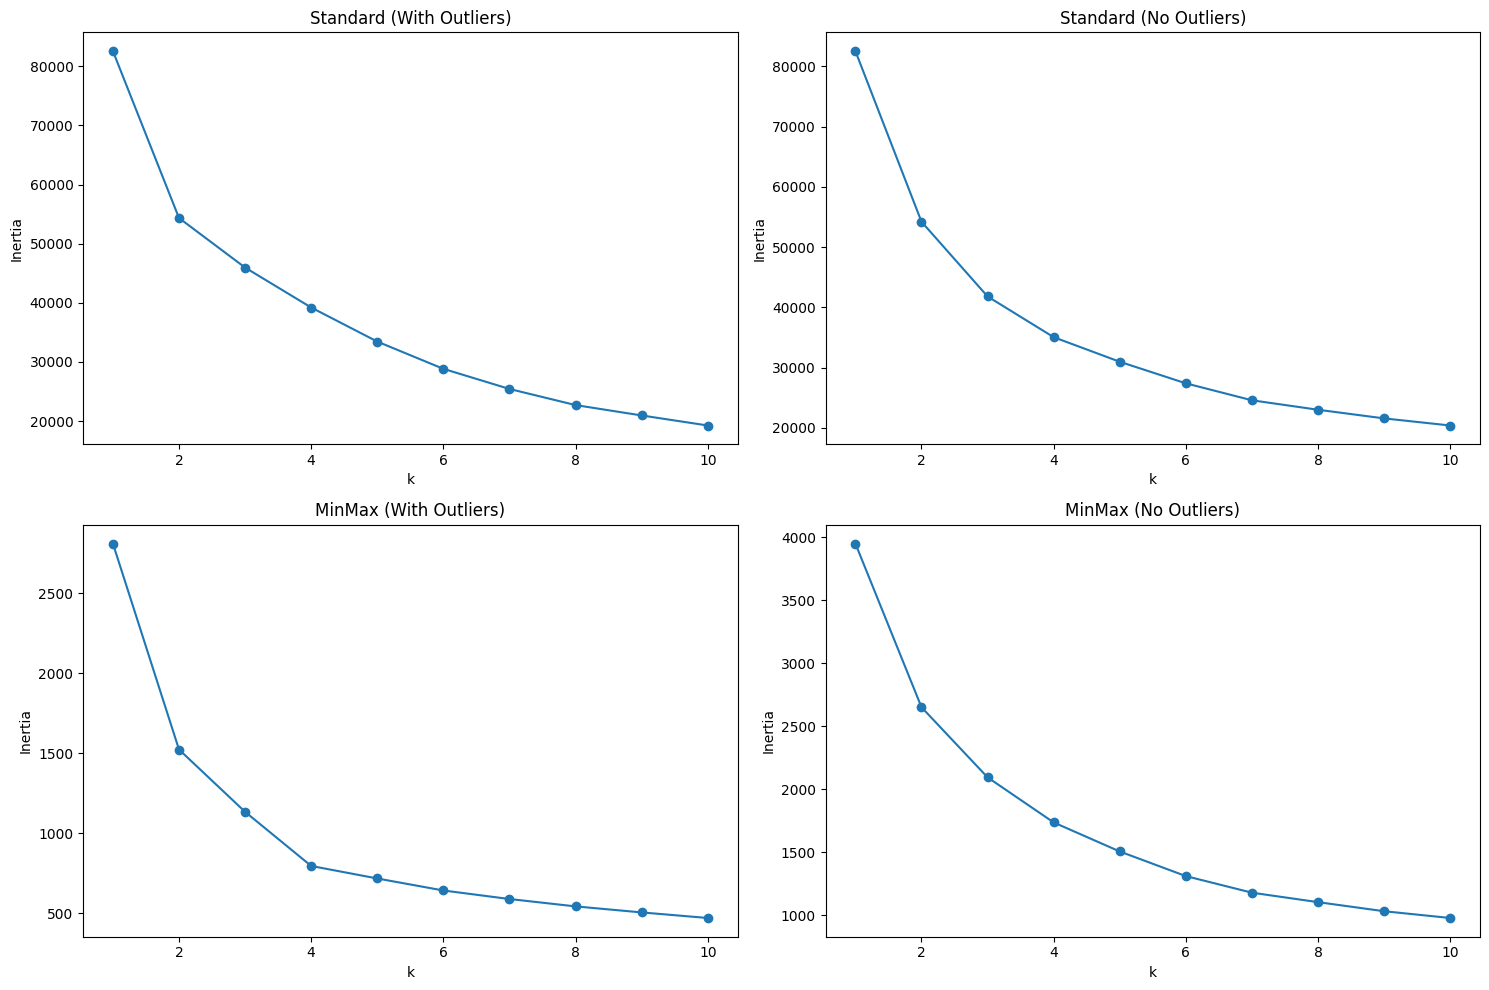

In [30]:
# Dictionary to hold our test subjects
datasets = {
    "Standard (With Outliers)": X_train_WITH_outliers_norm,
    "Standard (No Outliers)": X_train_WITHOUT_outliers_norm,
    "MinMax (With Outliers)": X_train_WITH_outliers_scal,
    "MinMax (No Outliers)": X_train_WITHOUT_outliers_scal
}

plt.figure(figsize=(15, 10))

for i, (name, data) in enumerate(datasets.items()):
    inertia = []
    for k in range(1, 11):
        km = KMeans(n_clusters= k, random_state= 10, n_init= 10)
        km.fit(data)
        inertia.append(km.inertia_)
    
    plt.subplot(2, 2, i+1)
    plt.plot(range(1, 11), inertia, marker='o')
    plt.title(name)
    plt.xlabel('k')
    plt.ylabel('Inertia')

plt.tight_layout()
plt.show()

## 7.1 Charts Conclusions
I AM very surprised about this result!

- **The Winner**: MinMax (With Outliers) The Shape: This graph has the sharpest, most aggressive "elbow" right at $k=2$ and another very clear bend at $k=4$.
- While it has the "sharpest" elbow, it's actually too sharp
- **Best for the Project: Standard (No Outliers) this is the one I calle the "Champion," and here is why it's the best for $k=6$.
- The Shape: Notice how the curve from $k=4$ to $k=10$ is much smoother and more consistent.

# Step 8. Build a K-Means Model
- Classify the data into 6 clusters using the K-Means model. 
- Then store the cluster to which each house belongs as a new column in the dataset. 
- You could call it cluster. To introduce it to your dataset, you may have to categorize it. See what format and values it has, and act accordingly. Plot it in a dot plot and describe what you see.

In [31]:
# 1. Initialize the Winner, K-Means with 6 clusters as requested
final_kmeans = KMeans(n_clusters= 6, random_state=10, n_init= 10) # ---> n_init: Number of times the k-means algorithm is run with different centroid seeds.

# 2. Fit and Predict on the Training Data
train_labels = final_kmeans.fit_predict(X_train_WITHOUT_outliers_norm)

# 3. Add to the original dataframe for analysis
X_train_WITHOUT_outliers['cluster'] = train_labels

# 4. Convert the 'cluster' column to a categorical type
X_train_WITHOUT_outliers['cluster'] = X_train_WITHOUT_outliers['cluster'].astype('category')

# Check the format and values
print(X_train_WITHOUT_outliers['cluster'].info())
print(X_train_WITHOUT_outliers['cluster'].value_counts())

<class 'pandas.Series'>
Index: 16512 entries, 12346 to 17673
Series name: cluster
Non-Null Count  Dtype   
--------------  -----   
16512 non-null  category
dtypes: category(1)
memory usage: 145.1 KB
None
cluster
2    4048
3    2775
4    2741
0    2677
1    2485
5    1786
Name: count, dtype: int64


In [32]:
X_train_WITHOUT_outliers.head()

MedInc  HouseAge  AveRooms  Latitude  Longitude cluster
12346  2.5212      21.0  5.897924     33.82    -116.52       4
19326  2.6316      46.0  6.229508     38.50    -122.94       1
16824  5.1550      31.0  5.030744     37.63    -122.49       5
6869   2.8229      16.0  4.700389     34.06    -118.11       4
16677  1.9653      41.0  5.258383     35.13    -120.66       2

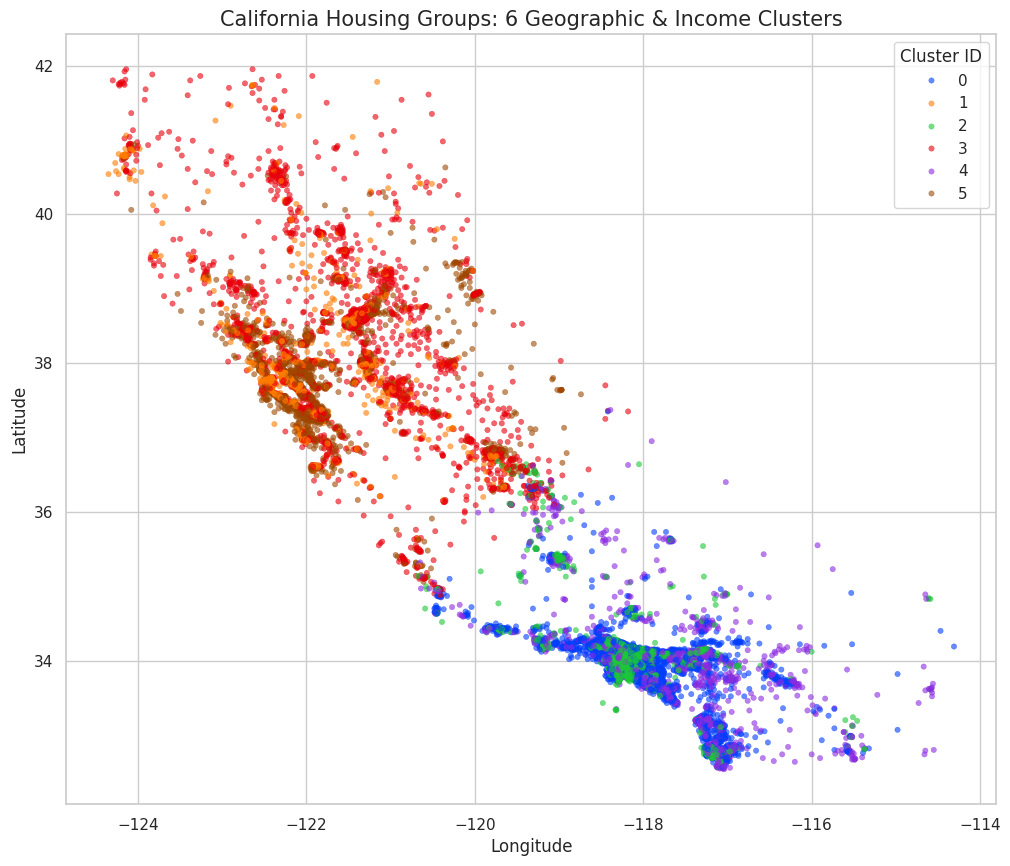

In [33]:
# Setting the aesthetic style
sns.set_theme(style= "whitegrid")

plt.figure(figsize=(12, 10))

# I use the original coordinates so the map looks correct (not scaled)
# but the color comes from the clusters we found using scaled data
sns.scatterplot(
    data= X_train_WITHOUT_outliers, 
    x= 'Longitude', 
    y= 'Latitude', 
    hue= 'cluster', 
    palette= 'bright',
    alpha= 0.6, 
    edgecolor= None, # Removes outlines for a cleaner 'cloud' look
    s= 15     
)

plt.title('California Housing Groups: 6 Geographic & Income Clusters', fontsize=15)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title='Cluster ID', loc='upper right')

plt.show()

## 8.1 Dot Chart Conclusions
1. The North-South Divided: The model has clearly split the state. Clusters 0 (Blue), 2 (Green), and 4 (Purple) dominate the Southern California region, while Clusters 1 (Orange), 3 (Red), and 5 (Brown) cover the Northern and Central regions.
2. Coastal vs. Inland Stratification: 
    - Cluster 2 (Green) and parts of Cluster 0 (Blue) are very tightly packed around the major metro areas.
    - Cluster 3 (Red) is the most widespread or rural areas where homes are more spread out.
3. Los Angeles area (Latitude 34). Blue, Green, and Purple dots all on top of each other.

In [34]:
# Group by cluster and look at the averages
description = X_train_WITHOUT_outliers.groupby('cluster').mean()
print(tabulate(description, headers= "keys", tablefmt= "psql"))

+-----------+----------+------------+------------+------------+-------------+
|   cluster |   MedInc |   HouseAge |   AveRooms |   Latitude |   Longitude |
|-----------+----------+------------+------------+------------+-------------|
|         0 |  5.83417 |    23.9216 |    6.67431 |    33.8647 |    -117.946 |
|         1 |  3.05694 |    42.5497 |    4.87174 |    37.9196 |    -121.948 |
|         2 |  3.09076 |    38.3995 |    4.56649 |    34.0187 |    -118.155 |
|         3 |  3.02692 |    18.9942 |    5.19272 |    38.0664 |    -121.434 |
|         4 |  2.98866 |    18.5921 |    4.55554 |    33.8572 |    -117.803 |
|         5 |  5.79848 |    24.3768 |    6.80064 |    37.7669 |    -121.777 |
+-----------+----------+------------+------------+------------+-------------+


## 8.2 Median Description by Cluster
- Grouping cluster and looking the avg. we can determined, for instance, what cluster has the highest MedInc or HouseAge.
- For example a higher MedInc could be the "Luxury" cluster and higher HouseAge "Old_time" cluster

## 8.3 Re-Run the Model with 3 asked Columns
- targeted_cols = ['Latitude', 'Longitude', 'MedInc']

In [35]:
# 1. Define the restricted feature list
targeted_features = ['Latitude', 'Longitude', 'MedInc']

# 2. Subset the scaled training data
# I use the 'norm' (StandardScaler) version as it's best for K-Means
X_train_targeted = X_train_WITHOUT_outliers_norm[targeted_features]

# 3. Fit the model with 6 clusters
kmeans_targeted = KMeans(n_clusters= 6, n_init= 10, random_state= 10)
targeted_labels = kmeans_targeted.fit_predict(X_train_targeted)

# 4. Store the new labels back in the original dataframe
X_train_WITHOUT_outliers['cluster_c3'] = targeted_labels
X_train_WITHOUT_outliers['cluster_c3'] = X_train_WITHOUT_outliers['cluster_c3'].astype('category')

print("New classification complete using 3 features.")

New classification complete using 3 features.


In [36]:
X_train_WITHOUT_outliers.head()

MedInc  HouseAge  AveRooms  Latitude  Longitude cluster cluster_c3
12346  2.5212      21.0  5.897924     33.82    -116.52       4          0
19326  2.6316      46.0  6.229508     38.50    -122.94       1          1
16824  5.1550      31.0  5.030744     37.63    -122.49       5          3
6869   2.8229      16.0  4.700389     34.06    -118.11       4          0
16677  1.9653      41.0  5.258383     35.13    -120.66       2          5

In [37]:
view_cols = ['Latitude', 'Longitude', 'MedInc', 'cluster_c3']
print(tabulate(X_train_WITHOUT_outliers[view_cols].head(), headers= "keys", tablefmt= "psql"))

+-------+------------+-------------+----------+--------------+
|       |   Latitude |   Longitude |   MedInc |   cluster_c3 |
|-------+------------+-------------+----------+--------------|
| 12346 |      33.82 |     -116.52 |   2.5212 |            0 |
| 19326 |      38.5  |     -122.94 |   2.6316 |            1 |
| 16824 |      37.63 |     -122.49 |   5.155  |            3 |
|  6869 |      34.06 |     -118.11 |   2.8229 |            0 |
| 16677 |      35.13 |     -120.66 |   1.9653 |            5 |
+-------+------------+-------------+----------+--------------+


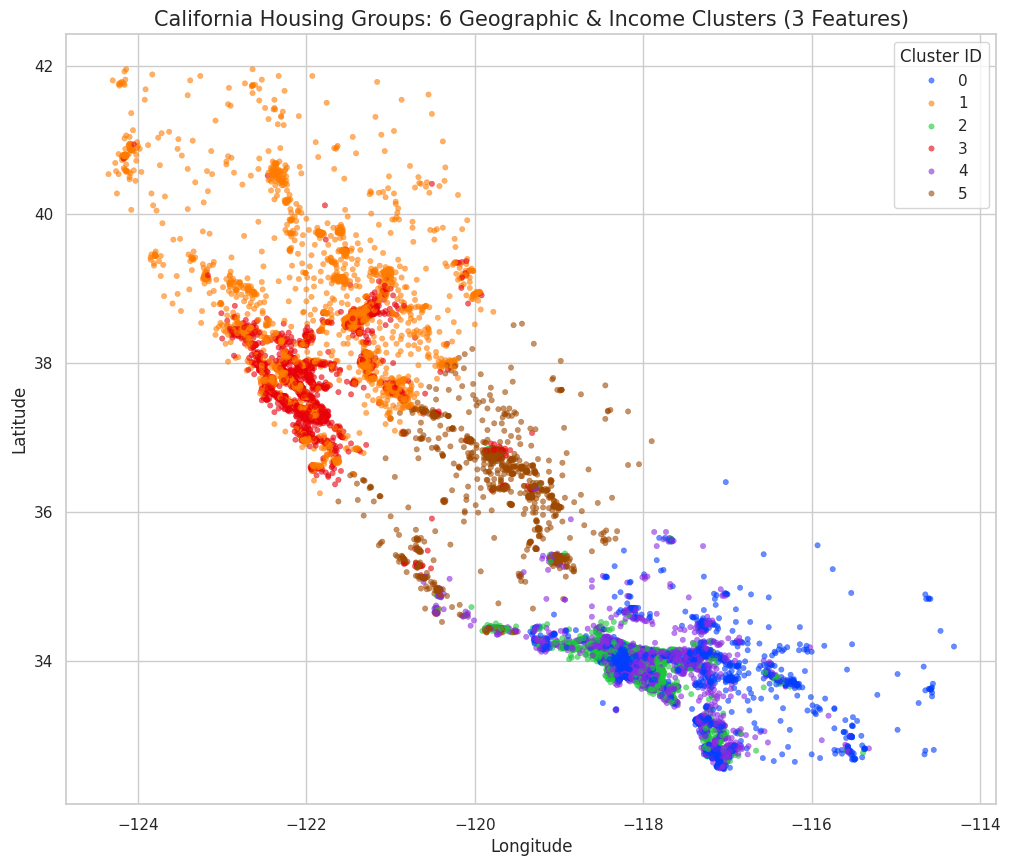

In [38]:
# Setting the aesthetic style
sns.set_theme(style= "whitegrid")

plt.figure(figsize=(12, 10))

# I use the original coordinates so the map looks correct (not scaled)
# but the color comes from the clusters we found using scaled data
sns.scatterplot(
    data= X_train_WITHOUT_outliers, 
    x= 'Longitude', 
    y= 'Latitude', 
    hue= 'cluster_c3', 
    palette= 'bright',
    alpha= 0.6, 
    edgecolor= None, # Removes outlines for a cleaner 'cloud' look
    s= 15     
)

plt.title('California Housing Groups: 6 Geographic & Income Clusters (3 Features)', fontsize=15)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title='Cluster ID', loc='upper right')

plt.show()

### 8.3.1 New Chart Conclusions
* Column Fetaures Geagraphics and income:
    - Geographic Solidification: the clusters are much more concentrated. Look at the Orange (1) and Brown (5) clusters in Northern/Central California. They now form distinct geographic bands.
    - Income Alignment: Because HouseAge is gone, the model is no longer splitting a neighborhood just because some houses are older. It is now grouping by where they are and how much money the residents make.
    - The Southern Hub: Look at the Los Angeles area (Latitude 34). The way the Blue (0), Green (2), and Purple (4) clusters interact has shifted to represent income.

# Step 9. Predict With The Test Set

In [39]:
# 1. Select the same 3 features from the scaled TEST data
targeted_features = ['Latitude', 'Longitude', 'MedInc']
X_test_targeted = X_test_WITHOUT_outliers_norm[targeted_features]

# 2. Predict the clusters for test set using using the trained model
test_labels = kmeans_targeted.predict(X_test_targeted)

# 3. Store the new labels back in the original dataframe
X_test_WITHOUT_outliers['cluster_c3'] = test_labels
X_test_WITHOUT_outliers['cluster_c3'] = X_test_WITHOUT_outliers['cluster_c3'].astype('category')

## 9.2 Plot Training vs. Test

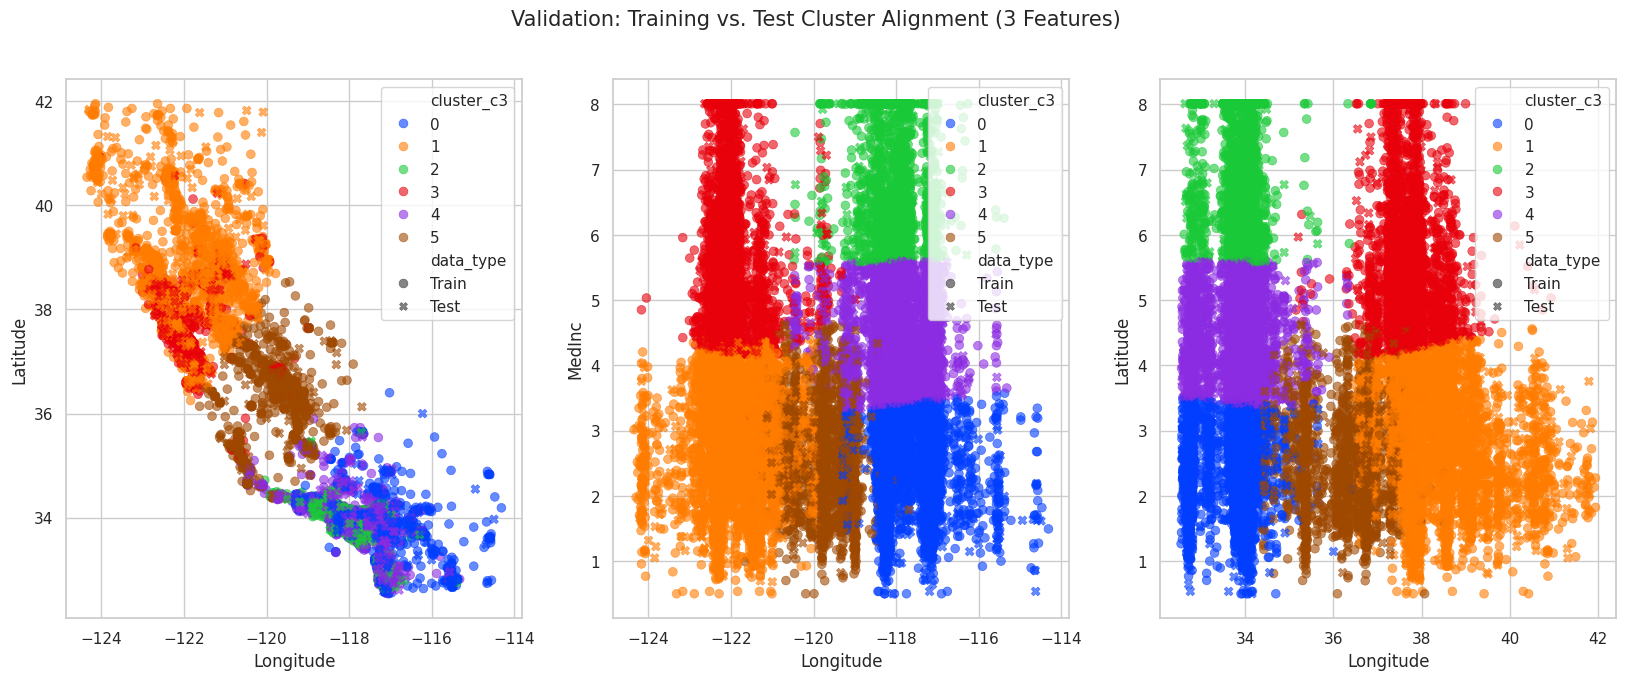

In [40]:
# Add a label to distinguish the sets inside the new plot
X_train_WITHOUT_outliers['data_type'] = 'Train'
X_test_WITHOUT_outliers['data_type'] = 'Test'

# Combine df temporarily just for the plotting
combined_df = pd.concat([X_train_WITHOUT_outliers, X_test_WITHOUT_outliers])

# Setting the aesthetic style
sns.set_theme(style= "whitegrid")

fig, axis = plt.subplots(1, 3, figsize=(20, 7))

# Plot training and test data
# 'style' allows us to see the difference between Train and Test markers
sns.scatterplot(ax= axis[0], data= combined_df, x= 'Longitude', y= 'Latitude', hue= 'cluster_c3', palette= 'bright',markers= {'Train': 'o', 'Test': 'X'},style= 'data_type',alpha= 0.6, edgecolor= None, s= 40)
sns.scatterplot(ax= axis[1], data= combined_df, x= 'Longitude', y= 'MedInc', hue= 'cluster_c3', palette= 'bright',markers= {'Train': 'o', 'Test': 'X'},style= 'data_type',alpha= 0.6, edgecolor= None, s= 40)
sns.scatterplot(ax= axis[2], data= combined_df, x= 'Latitude', y= 'MedInc', hue= 'cluster_c3', palette= 'bright',markers= {'Train': 'o', 'Test': 'X'},style= 'data_type',alpha= 0.6, edgecolor= None, s= 40)


plt.suptitle('Validation: Training vs. Test Cluster Alignment (3 Features)', fontsize= 15)
plt.xlabel('Longitude', fontsize= 12)
plt.ylabel('Latitude', fontsize= 12)
plt.legend(loc= 'upper right')

plt.show()

### 9.2.1 Trainin vs. Test Plot Conclusion
- The K-Means model was successfully validated using the test set. 
- By plotting both datasets, we can see that the test observations (marked with 'X') align perfectly with the established training clusters. 
- This confirms that the 6 clusters based on Latitude, Longitude, and Median Income are robust and reliable.

# Step 10. Train a Supervised Classification Model
- Now that K-Means has returned a categorization (clustering) of the points for the training and test sets, study which model might be most useful and train it. 
- Get the statistics and describe what you see.

* **To move into the supervised classification step**:
    - I will use a Random Forest Classifier. Because it handles the non-linear boundaries created by K-Means very well.

In [41]:
# Removing the helper column after plotting
# This a viatl step to move forward and avoid having data that we dont need in the dataset
X_train_WITHOUT_outliers.drop(columns= ['data_type'], inplace= True)
X_test_WITHOUT_outliers.drop(columns= ['data_type'], inplace= True)

In [42]:
# Prepare the features, the X and the y target
features = ['Latitude', 'Longitude', 'MedInc']

X_train_final = X_train_WITHOUT_outliers_norm[features]
y_train_final = X_train_WITHOUT_outliers['cluster_c3']

X_test_final = X_test_WITHOUT_outliers_norm[features]
y_test_final = X_test_WITHOUT_outliers['cluster_c3']

# Trainin the Random Forest model. Let's see this MUCHACHOS!!
supervised_model = RandomForestClassifier(n_estimators= 100, random_state= 10)
supervised_model.fit(X_train_final, y_train_final)

y_pred_final = supervised_model.predict(X_test_final)

Overall Accuaracy: 0.9937

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       962
           1       1.00      1.00      1.00       994
           2       0.99      0.99      0.99       382
           3       0.99      0.99      0.99       530
           4       0.99      0.99      0.99       935
           5       1.00      0.98      0.99       325

    accuracy                           0.99      4128
   macro avg       0.99      0.99      0.99      4128
weighted avg       0.99      0.99      0.99      4128



<Figure size 500x500 with 0 Axes>

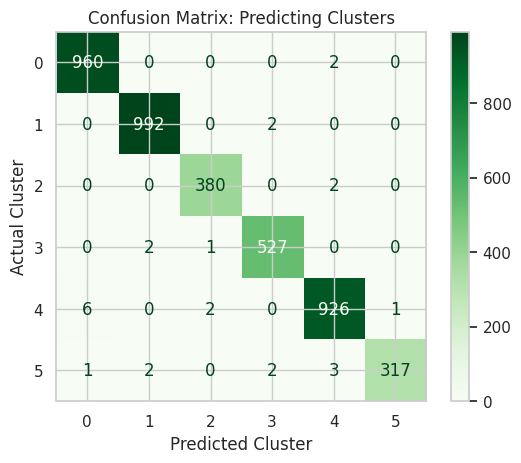

In [ ]:
print(f"Overall Accuaracy: {accuracy_score(y_test_final, y_pred_final):.4f}")
print("\nClassification Report:\n", classification_report(y_test_final, y_pred_final))

# Plot Confusion Matrix
plt.figure(figsize=(5,5))
cm = confusion_matrix(y_test_final, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= supervised_model.classes_)
disp.plot(cmap= 'Greens')
plt.title('Confusion Matrix: Predicting Clusters')
plt.xlabel('Predicted Cluster')
plt.ylabel('Actual Cluster')

plt.show()

# Step 11. Saving the Models

kmeans_targeted = KMeans(n_clusters= 6, n_init= 10, random_state= 10)
supervised_model = RandomForestClassifier(n_estimators= 100, random_state= 10)



In [61]:
with open("../models/unsupervised_kmeans_targeted_nclu6_n_init10_rs10.pkl", "wb") as file:
  pickle.dump(kmeans_targeted, file)

with open("../models/supervised_model_n_est100_rs10.pkl", "wb") as file:
  pickle.dump(supervised_model, file)

# FINAL CONCLUSION
**What a hit!**
- The supervised Random Forest model achieved an outstanding accuracy of 99.37% in predicting cluster membership. 
- The classification report and confusion matrix demonstrate that the model can perfectly replicate the K-Means logic. 
- This proves that the geographic and socioeconomic boundaries established in the clustering phase are distinct, stable, and highly predictable. 
- The model is most successful in identifying high-income regions (Clusters 1 and 0) where the precision reached 100% and 99% respectively.

I LOVE THIS KIND OF PROJECTS!!